In [1]:
from util_mjw.MicFileTool import MicFile
import util_mjw.Simulation as Gsim
import util_mjw.RotRep as Rot
import numpy as np
import matplotlib.pyplot as plt
from util_mjw.config import Config
from scipy import ndimage
from scipy.ndimage.measurements import label,find_objects,center_of_mass
from scipy import optimize
import json
import os
from util_mjw.calibration_misc import getCenter2,fetch_images,process_images,GetVertex,optimize_detector
import util.Simulation as sim
import h5py
from scipy.interpolate import griddata

# Extract the windows around the Bragg Peaks from a small grain

In [ ]:
mic_in_file = "AuxData/Ti7_WithHRM_2ndLoad_z1_.mic.LBFS"
mic_out_file = "Ti7HRM2nd.hdf5"

In [2]:
a=MicFile()
grid_x,grid_y=np.meshgrid(np.arange(-0.5,0.2,0.002),np.arange(-0.4,0.4,0.002))
grid_c = griddata(a.snp[:,0:2],a.snp[:,9],(grid_x,grid_y),method='nearest')
grid_e1 = griddata(a.snp[:,0:2],a.snp[:,6],(grid_x,grid_y),method='nearest')
grid_e2 = griddata(a.snp[:,0:2],a.snp[:,7],(grid_x,grid_y),method='nearest')
grid_e3 = griddata(a.snp[:,0:2],a.snp[:,8],(grid_x,grid_y),method='nearest')

g = np.where(grid_c>0.8,1,0)

labels,num_features = label(g)

ll = np.float32(labels.copy())
ll[ll==0] = np.nan


GrainDict={}
for l in np.sort(np.unique(labels))[1:]:
    
    com =center_of_mass(g,labels,l)
    com = (int(com[0]),int(com[1]))
    GrainDict[l] = (grid_e1[com],grid_e2[com],grid_e3[com])
GrainIDMap=np.zeros(grid_c.shape,dtype=int)
for grainID in GrainDict:
    
    (e1,e2,e3)=GrainDict[grainID]
    tmp = grid_c > 0.3
    tmp*=np.absolute(grid_e1 - e1)<1
    tmp*=np.absolute(grid_e2 - e2)<1
    tmp*=np.absolute(grid_e3 - e3)<1
    GrainIDMap[tmp]= grainID 

with h5py.File(Cfg.micFile,'w') as f:
    ds=f.create_dataset("origin", data = np.array([-0.5,-0.4]))
    ds.attrs[u'units'] = u'mm'
    ds=f.create_dataset("stepSize", data = np.array([0.002,0.002]))
    ds.attrs[u'units'] = u'mm'
    f.create_dataset("Xcoordinate", data = grid_x)
    f.create_dataset("Ycoordinate", data = grid_y)
    f.create_dataset("Confidence", data = grid_c)
    f.create_dataset("Ph1", data = grid_e1)
    f.create_dataset("Psi", data = grid_e2)
    f.create_dataset("Ph2", data = grid_e3)
    f.create_dataset("GrainID", data = GrainIDMap)
    
gg = np.float32(GrainIDMap.copy())
gg[gg==0] = np.nan
fig,ax = plt.subplots(ncols=4,figsize=(20,7))
ax[0].imshow(grid_e3,origin='lower')
ax[1].imshow(g,origin='lower')
ax[2].imshow(ll,origin='lower')
ax[3].imshow(gg,origin='lower')
plt.show()
print(GrainIDMap.max())

NameError: name 'Cfg' is not defined

In [2]:
############ Experimental Parameters ##########
grain_ID = 24
Cfg = Config(f'ConfigFiles/test_all/Grain_{grain_ID}.yml')
path = f'Calibration_Files/grain_{grain_ID}/'


################### raw data #######################
raw_data='/mnt/data/sparrow_data/NF-DataSets/2013-07_NF-Strain1/V/Suter_Jul13/NF/Ti7_WithHRM_Under2ndLoad/Ti7_WithHRM_Under2ndLoad__'

if f'grain_{grain_ID}' not in os.listdir('Calibration_Files/'):
    os.mkdir(path)
    os.mkdir(path+'Ps_bf/')
    os.mkdir(path+'Ps_filtered/')
    
      

In [3]:
Det1=Gsim.Detector(config=Cfg)
crystal_str=Gsim.CrystalStr(config=Cfg)
crystal_str.getRecipVec()
crystal_str.getGs(Cfg.maxQ)
o_mat=Rot.EulerZXZ2Mat(np.array(Cfg.euler)/180.0*np.pi)
pks,Gs,Info=Gsim.GetProjectedVertex(Det1,crystal_str,o_mat,Cfg.etalimit/180*np.pi,
                                    Cfg.grainPos,getPeaksInfo=True,
                                    omegaL=Cfg.omgRange[0],omegaU=Cfg.omgRange[1],energy=Cfg.energy)


In [5]:
# allpks,alllims = fetch_images(raw_data,pks,window,dx,dy,path)
# flucThresh=4
# Nfile = len(allpks)
# Im = process_images(path,Nfile,window,flucThresh)
# goodidx = np.arange(Nfile)

# Find the Center of Mass of each Bragg Peak

# Write down all the center of mass for the good Peaks

In [6]:
center_of_mass = []
goodidx = np.arange(45)
for idx in goodidx:
    tmp=np.load(path+f'Ps_filtered/Im{idx}.npy')
    Omeg = np.argmax(tmp[18:30,50:100,100:200].sum(axis=(1,2)))+18
    Py,Px,cy,cx,co = getCenter2(tmp,Omeg,dx=50,dy=50,do=5)
    center = np.array([co,cx,cy])
    center_of_mass.append(center)
center_of_mass = np.stack(center_of_mass)

# Start Calibration

In [7]:
x,oldPs,newPs,absCOM,goodidx = optimize_detector(path,center_of_mass,goodidx,Cfg)

# Check the position of simulated Bragg peaks after calibration

In [11]:
dist0 = np.absolute(np.linalg.norm(oldPs-absCOM,axis=1)).mean()
dist1 = np.absolute(np.linalg.norm(newPs-absCOM,axis=1)).mean()
print(dist0,dist1)
print(len(oldPs))

1.6812524785223308 0.6012475879505154
22


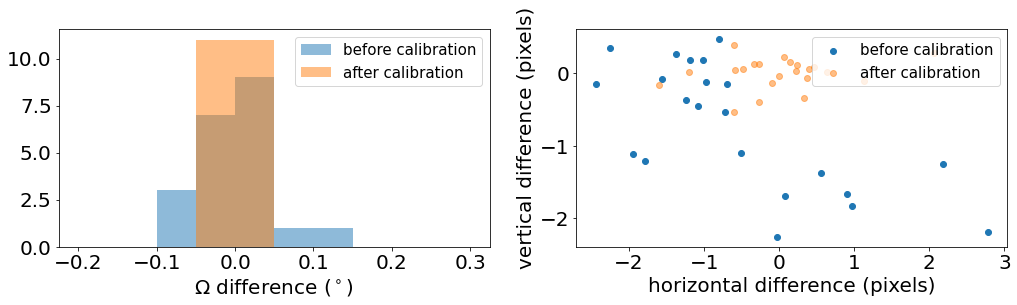

In [9]:
fig,ax=plt.subplots(1,2,figsize=(17,4))
ax[0].hist(oldPs[:,2]-absCOM[:,2],label='before calibration',bins=np.arange(-0.2,0.35,0.05),alpha=0.5)
ax[0].hist(newPs[:,2]-absCOM[:,2],label='after calibration',bins=np.arange(-0.2,0.35,0.05),alpha=0.5)
ax[0].legend(loc='upper right', fontsize=15)
ax[0].set_xlabel(r'$\Omega$ difference $(^\circ)$', fontsize=20)
ax[1].scatter(oldPs[:,0]-absCOM[:,0],oldPs[:,1]-absCOM[:,1],label='before calibration')
ax[1].scatter(newPs[:,0]-absCOM[:,0],newPs[:,1]-absCOM[:,1],label='after calibration',alpha=0.5)
ax[1].set_xlabel('horizontal difference (pixels)', fontsize=20)
ax[1].set_ylabel('vertical difference (pixels)', fontsize=20)
ax[1].legend(loc='upper right', fontsize=15)
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=20)
plt.savefig('calibration.png',dpi=100,bbox_inches='tight')
plt.show()

In [10]:
import yaml

x = list([float(xx) for xx in x])

for i in range(40):
    if f'Grain_{i}.yml' in os.listdir('ConfigFiles/test_all/'):
        with open(f'ConfigFiles/test_all/Grain_{i}.yml') as f:
            data = yaml.safe_load(f)
    
        
        with open(f'ConfigFiles/test_all/Grain_{i}.yml', 'w') as file:
            data['JCenter'] += float(x[0])
            data['KCenter'] += float(x[1])
            data['Ldistance'] += float(x[2]*1e-3)
            data['tilt'] = [float(a) for a in list(np.array(data['tilt'])+x[3:6])]
            data['grainPos'] = [float(a) for a in list(np.array(data['grainPos'])+np.array([x[6],x[7],0])*1e-3)]
            documents = yaml.dump(data, file)